In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
data = pd.read_csv('../data/num_file/min_01/p040.csv')

In [3]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00     23
1       2022-04-21 01:41:00    150
2       2022-04-21 01:42:00     27
3       2022-04-21 01:43:00      0
4       2022-04-21 01:44:00      0
...                     ...    ...
194995  2022-09-03 11:35:00    310
194996  2022-09-03 11:36:00    461
194997  2022-09-03 11:37:00    503
194998  2022-09-03 11:38:00    473
194999  2022-09-03 11:39:00    423

[195000 rows x 2 columns]


If there is no people, use NaN.

In [4]:
data.loc[data['count']==0, 'count'] = np.NaN

In [5]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00   23.0
1       2022-04-21 01:41:00  150.0
2       2022-04-21 01:42:00   27.0
3       2022-04-21 01:43:00    NaN
4       2022-04-21 01:44:00    NaN
...                     ...    ...
194995  2022-09-03 11:35:00  310.0
194996  2022-09-03 11:36:00  461.0
194997  2022-09-03 11:37:00  503.0
194998  2022-09-03 11:38:00  473.0
194999  2022-09-03 11:39:00  423.0

[195000 rows x 2 columns]


<Axes: >

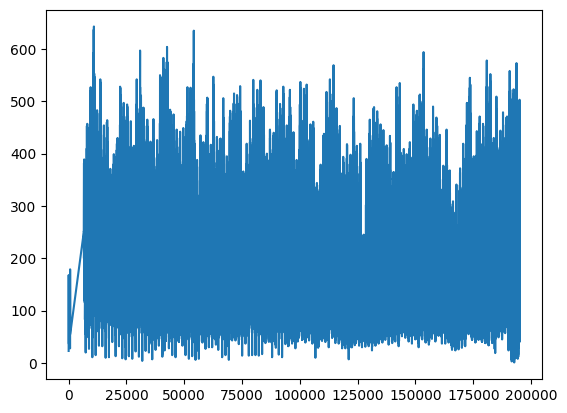

In [6]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

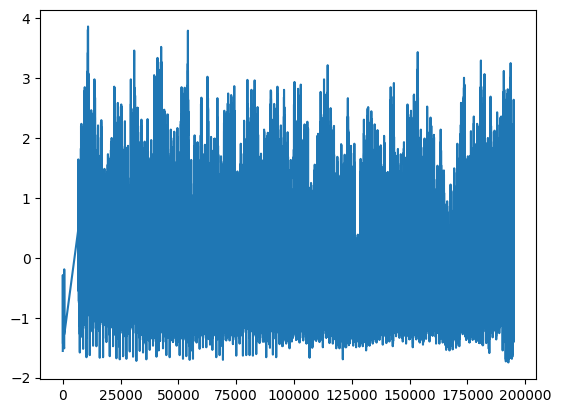

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [8]:
print(data)

                   datetime     count
0       2022-04-21 01:40:00 -1.554014
1       2022-04-21 01:41:00 -0.443766
2       2022-04-21 01:42:00 -1.519046
3       2022-04-21 01:43:00 -1.476925
4       2022-04-21 01:44:00 -1.434803
...                     ...       ...
194995  2022-09-03 11:35:00  0.954972
194996  2022-09-03 11:36:00  2.275031
194997  2022-09-03 11:37:00  2.642200
194998  2022-09-03 11:38:00  2.379936
194999  2022-09-03 11:39:00  1.942831

[195000 rows x 2 columns]


In [9]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [10]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [11]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [12]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [13]:
input_data = Input(shape=(time_step, 1))
x = LSTM(time_step, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [14]:
model = Model(input_data, output_data)

In [15]:
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 batch_normalization (BatchN  (None, 10, 10)           40        
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 1)            11        
 ibuted)                                                         
                                                                 
Total params: 531
Trainable params: 511
Non-trainable params: 20
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
1097/1097 [==============================] - 5s 4ms/step - loss: 0.0649 - mae: 0.1778 - val_loss: 0.0603 - val_mae: 0.1641
Epoch 2/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0613 - mae: 0.1740 - val_loss: 0.0608 - val_mae: 0.1638
Epoch 3/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0596 - mae: 0.1713 - val_loss: 0.0590 - val_mae: 0.1663
Epoch 4/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0598 - mae: 0.1720 - val_loss: 0.0590 - val_mae: 0.1670
Epoch 5/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0583 - mae: 0.1700 - val_loss: 0.0571 - val_mae: 0.1620
Epoch 6/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0582 - mae: 0.1700 - val_loss: 0.0565 - val_mae: 0.1581
Epoch 7/100
1097/1097 [==============================] - 4s 4ms/step - loss: 0.0583 - mae: 0.1704 - val_loss: 0.0562 - val_mae: 0.1578
Epoch 8/100
1097/1097 [==============================] 

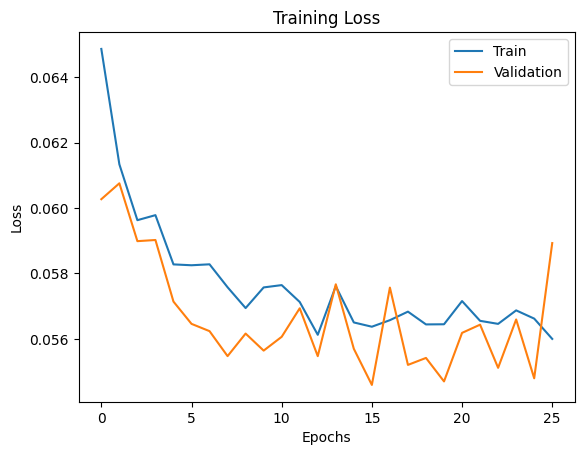

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [18]:
predict_test = model.predict(encode_input_data_test)

1219/1219 [==============================] - 1s 977us/step


In [19]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

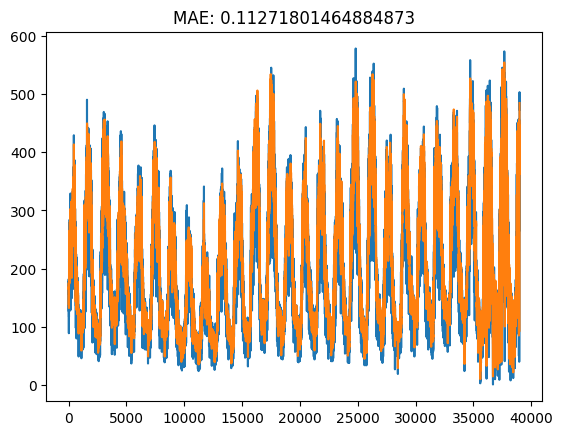

In [20]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

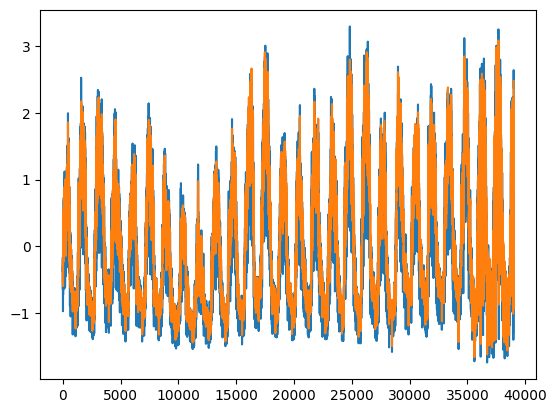

In [21]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [22]:
print(predict_test_data)

[[139.1536 ]
 [142.8765 ]
 [142.60463]
 ...
 [380.57162]
 [467.80597]
 [484.2987 ]]


In [23]:
print(decode_output_test_data)

[[128.]
 [140.]
 [163.]
 ...
 [461.]
 [503.]
 [473.]]
